In [228]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

In [229]:
import warnings
warnings.filterwarnings("ignore")

In [230]:
import pickle as pk
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier 
from xgboost import XGBRFClassifier
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.model_selection import StratifiedKFold

From the EDA we know,the dataset contains null, duplicate values and some amount of outliers. \
From the EDA we know, that some categorical type data columns are highly imbalanced. \
We have also observed that how distribution differs with the different categories and the different %Churn for different columns.

In [231]:
df=pd.read_csv('../artifact/data.csv')

In [232]:
df.duplicated().sum()

0

In [233]:
df.isnull().sum()

customerID          0
gender              1
SeniorCitizen       4
Partner             3
Dependents          4
tenure              2
PhoneService        3
MultipleLines       3
InternetService     3
OnlineSecurity      2
OnlineBackup        1
DeviceProtection    2
TechSupport         2
StreamingTV         5
StreamingMovies     0
Contract            2
PaperlessBilling    1
PaymentMethod       4
MonthlyCharges      0
TotalCharges        6
Churn               2
dtype: int64

In [234]:
df.drop(columns=['customerID'],inplace=True)

In [235]:
df.dtypes

gender               object
SeniorCitizen       float64
Partner              object
Dependents           object
tenure              float64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object

In [236]:
df['SeniorCitizen']=df['SeniorCitizen'].astype('category') 

In [237]:
#Categorical Imputer
cat_impute=SimpleImputer(strategy='most_frequent')
cat_col=df.select_dtypes(include=['category','object']).columns.values
df[cat_col]=cat_impute.fit_transform(df[cat_col])

In [238]:
df[cat_col].isna().sum().sum()

0

In [239]:
#Numerical values, since the number null in numerical columns  are very low we'll just drop them
df.dropna(inplace=True) 
df.reset_index(inplace=True,drop=True)

In [240]:
df.isnull().sum().sum()

0

### Hypothesis Testing
We can statistically check whether all the independent variables has significant effect on target variables

In [241]:
numerical_cols = df.select_dtypes(include=[np.number])

# Group by 'Churn' and calculate the mean of numerical columns
class_summary = df.groupby('Churn')[numerical_cols.columns].agg(np.mean) 
class_summary

,tenure,MonthlyCharges,TotalCharges
Churn,,,
No,37.656867,61.523704,2564.930667
Yes,18.137265,74.675496,1545.221367


We can see the difference between in mean of all continious values. \
It suggests that there may be some relation between the continious values and Churn.

Null Hypothesis (H0): The means of the numerical feature for churned and non-churned customers are the same. Any observed difference is due to random chance. \
Alternative Hypothesis (H1): The means of the numerical feature for churned and non-churned customers are different. This suggests a potential relationship between the feature and churn behavior.

In [242]:
for i in df.select_dtypes(include='number').columns.values:
    x=np.array(df[df.Churn=='No'][i])
    y=np.array(df[df.Churn=='Yes'][i])
    t,p_value=ttest_ind(x,y,axis=0,equal_var=False)
    print('For the column',i, '{} P_value:{}'.format('\033[1m',p_value))
    if p_value<0.05:
        print('{} Reject Null Hypothesis.{} of Churned and non-churned Customer are not the same'.format('\033[1m',i))
    else:
        print('{} Fail to Reject Null Hypothesis.{} of Churned and non-churned Customer are  same'.format('\033[1m',i))
    print('\n')

For the column tenure  P_value:2.7539972292832127e-221
 Reject Null Hypothesis.tenure of Churned and non-churned Customer are not the same


For the column MonthlyCharges  P_value:7.088838995641746e-69
 Reject Null Hypothesis.MonthlyCharges of Churned and non-churned Customer are not the same


For the column TotalCharges  P_value:5.207968082025042e-73
 Reject Null Hypothesis.TotalCharges of Churned and non-churned Customer are not the same




We know that the data for Churn and Non-Churn are the same are independet for all the continious values.

#### Chi-Squared Test
Now testing for the categorical columns, we'll use chi-squared test.

In [243]:
col_cat=list(df.select_dtypes(include=['category','object']).columns)
col_cat.remove('Churn')

In [244]:
for c in col_cat:
    ct=pd.crosstab(df['Churn'],df[c])
    chi,p_v,dof,expected=chi2_contingency(ct)
    s=c.capitalize()+':'
    print('\033[1m'+s+'\033[0m')
    print('\n')
    if p_v<0.05:
        print('Reject the Null Hypothesis.\nThere is significant difference between target and {}'.format(c))
    else:
        print('Fail to reject the Null Hypothesis.\nThere is no significant difference between target and {}'.format(c))
    print('\n')


Gender:


Fail to reject the Null Hypothesis.
There is no significant difference between target and gender


Seniorcitizen:


Reject the Null Hypothesis.
There is significant difference between target and SeniorCitizen


Partner:


Reject the Null Hypothesis.
There is significant difference between target and Partner


Dependents:


Reject the Null Hypothesis.
There is significant difference between target and Dependents


Phoneservice:


Fail to reject the Null Hypothesis.
There is no significant difference between target and PhoneService


Multiplelines:


Reject the Null Hypothesis.
There is significant difference between target and MultipleLines


Internetservice:


Reject the Null Hypothesis.
There is significant difference between target and InternetService


Onlinesecurity:


Reject the Null Hypothesis.
There is significant difference between target and OnlineSecurity


Onlinebackup:


Reject the Null Hypothesis.
There is significant difference between target and OnlineBackup




Therefore statistically we've proved that PhoneService Variable has no effect on the target variable.

In [245]:
df.drop(columns=['gender','PhoneService'],axis=1,inplace=True)

#### Label Encoding Binary Columns

In [246]:
target_col=['Churn']
cat_col=df.select_dtypes(include=['category','object'])
num_col=df.select_dtypes(include='number')
bin_cat=df.nunique()[df.nunique()==2].index.values
multi_col=[i for i in cat_col if i not in bin_cat ]

In [247]:
encoders = {}

# Apply LabelEncoding and store the encoder for each column
for col in bin_cat:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    encoders[col] = le

# Save the dictionary of encoders
with open('label_encoders.pkl', 'wb') as file:
    pk.dump(encoders, file)

In [248]:
#one-hot ecnodeing
df=pd.get_dummies(data=df,columns=multi_col,drop_first=True)

Index(['SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges',
       'Churn'],
      dtype='object')



 Index(['SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PaperlessBilling',
       'MonthlyCharges', 'TotalCharges', 'Churn',
       'MultipleLines_No phone service', 'MultipleLines_Yes',
       'InternetService_Fiber optic', 'InternetService_No',
       'OnlineSecurity_No internet service', 'OnlineSecurity_Yes',
       'OnlineBackup_No internet service', 'OnlineBackup_Yes',
       'DeviceProtection_No internet service', 'DeviceProtection_Yes',
       'TechSupport_No internet service', 'TechSupport_Yes',
       'StreamingTV_No internet service', 'StreamingTV_Yes',
       'StreamingMovies_No internet service', 'StreamingMovies_Yes',
       'Cont

In [249]:
std=StandardScaler()
scaled=std.fit_transform(num_col)
scaled=pd.DataFrame(scaled,columns=num_col.columns)

In [250]:
with open('../artifact/scaler.pkl','wb') as file:
    pk.dump(std,file)

In [251]:
df_data_org=df.copy()
df=df.drop(columns=list(num_col.columns.values),axis=1)
df=df.merge(scaled,left_index=True,right_index=True,how='left')

In [252]:
data=df.drop(columns=['Churn'],axis=1)

#### Correlation Check

In [253]:
thersold=0.9
#Absolute value of correlation Matrix
corr_matrix=data.corr().abs()
corr_matrix.head()
#Upper Traingle matrix
upper=corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(bool))
upper
to_drop= [col for col in upper.columns if any(upper[col]>thersold)]
to_drop

['OnlineSecurity_No internet service',
 'OnlineBackup_No internet service',
 'DeviceProtection_No internet service',
 'TechSupport_No internet service',
 'StreamingTV_No internet service',
 'StreamingMovies_No internet service']

<b>We have 7 columns to drop</b>

In [254]:
df.drop(columns=to_drop,axis=1,inplace=True)

#### <b>Target Imbalance</b>

<Axes: ylabel='count'>

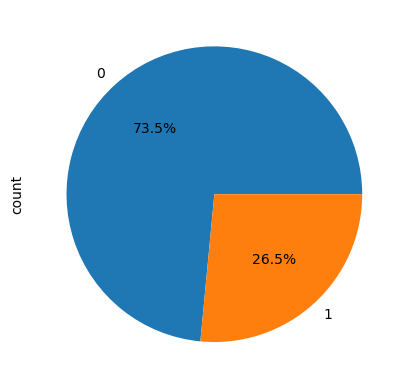

In [255]:
df['Churn'].value_counts().plot(kind='pie',autopct='%1.1f%%')

We can see that the Target variable is highly Imbalanced.
Therefore Sampling is needed

#### Train Test Sampling

In [256]:
x=df.drop(columns='Churn')
y=df['Churn']

In [257]:
from sklearn.model_selection import train_test_split

In [258]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=3)

#### Model Training, Testing and Tuning
Base Model (without Sampling)

### Decision Tree Model:

In [259]:
model_dt=DecisionTreeClassifier()
model_dt.fit(x_train,y_train)
y_pred=model_dt.predict(x_test)
print("Performance on train data: ",model_dt.score(x_train,y_train))
print("Performance on test data: ",model_dt.score(x_test,y_test))

Performance on train data:  0.9979691307879772
Performance on test data:  0.720037896731407


We can see that the Model overfits the test data

#### Confusion Matrix

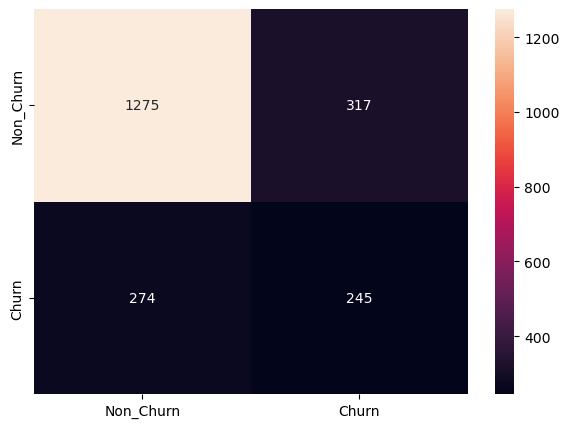

In [260]:
cm=confusion_matrix(y_test,y_pred,labels=[0,1])
df_cm=pd.DataFrame(cm,index= ['Non_Churn','Churn'],columns=['Non_Churn','Churn'])
plt.figure(figsize=(7,5))
sns.heatmap(df_cm,annot=True,fmt='g')
plt.show()

In [261]:
from sklearn.metrics import classification_report

In [262]:
print("classification_report:\n ",classification_report(y_test,y_pred))

classification_report:
                precision    recall  f1-score   support

           0       0.82      0.80      0.81      1592
           1       0.44      0.47      0.45       519

    accuracy                           0.72      2111
   macro avg       0.63      0.64      0.63      2111
weighted avg       0.73      0.72      0.72      2111



We can see that the model can predict 0 with and 83% recall however, the recall for 1 is 46% only.

This shows the imbalance of the data.

Thus we'll perform sampling and check how values imporves the recalls.

#### SMOTE

In [263]:
smote=SMOTE(random_state=3)
x_train_res,y_train_res=smote.fit_resample(x_train,y_train)

In [264]:
model_rs=DecisionTreeClassifier()
model_rs.fit(x_train_res,y_train_res)
y_pred=model_rs.predict(x_test)
print("Performance on train data: ",model_rs.score(x_train_res,y_train_res))
print("Performance on test data: ",model_rs.score(x_test,y_test))
print("Classification Matrix:\n",classification_report(y_test,y_pred))


Performance on train data:  0.9986025712688653
Performance on test data:  0.709616295594505
Classification Matrix:
               precision    recall  f1-score   support

           0       0.84      0.76      0.80      1592
           1       0.43      0.55      0.48       519

    accuracy                           0.71      2111
   macro avg       0.63      0.66      0.64      2111
weighted avg       0.74      0.71      0.72      2111



The accuracy of the train data is still very high and the accuracy of the test-data is still in the same range

Even after Sample Overfitting we're still getting very less values of the recall.

We will use <b>regularization</b> i.e. we'll limit the max_deapth of the tree and print the accuracy


In [265]:
clf_pruned=DecisionTreeClassifier(max_depth=3,random_state=100,min_samples_leaf=3)
clf_pruned.fit(x_train_res,y_train_res)

DecisionTreeClassifier(max_depth=3, min_samples_leaf=3, random_state=100)

In [266]:
y_pred=clf_pruned.predict(x_test)
print("Performance for train dataset: ",clf_pruned.score(x_train_res,y_train_res))
print("Performance for test dataset: ",clf_pruned.score(x_test,y_test))


Performance for train dataset:  0.7467859139183901
Performance for test dataset:  0.7508289909995263


In [267]:
print("Classification report:\n",classification_report(y_test,y_pred))

Classification report:
               precision    recall  f1-score   support

           0       0.87      0.79      0.83      1592
           1       0.49      0.63      0.55       519

    accuracy                           0.75      2111
   macro avg       0.68      0.71      0.69      2111
weighted avg       0.78      0.75      0.76      2111



The model, after limiting the max_deapth has imporved. \
There is no overfitting \
We have used SMOTE and hyperparameter tuning to achive a better model.
We will use GridSearchCV to find the best model.

#### Grid Search CV

In [268]:
params={'max_depth':np.arange(1,5),'criterion':['entropy','gini'],
        'max_features':np.arange(1,10),'min_samples_leaf':np.arange(1,5)}

In [269]:
gs=GridSearchCV(DecisionTreeClassifier(random_state=5),params,cv=5)
gs.fit(x_train_res,y_train_res)

KeyboardInterrupt: 

In [127]:
gs.best_params_

{'criterion': 'gini', 'max_depth': 4, 'max_features': 5, 'min_samples_leaf': 1}

In [128]:
best_cf=DecisionTreeClassifier(**gs.best_params_)
best_cf.fit(x_train_res,y_train_res)

DecisionTreeClassifier(max_depth=4, max_features=5)

In [ ]:
y_pred=best_cf.predict(x_test)
print("Performance on Train data: ",best_cf.score(x_train_res,y_train_res))
print("Performance on Test data: ",best_cf.score(x_test,y_test))
print("Classification Report:\n",classification_report(y_test,y_pred))

Performance on Train data:  0.7400782560089435
Performance on Test data:  0.7143533870203695
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.72      0.79      1592
           1       0.45      0.71      0.55       519

    accuracy                           0.71      2111
   macro avg       0.67      0.71      0.67      2111
weighted avg       0.78      0.71      0.73      2111



The model doesn't overfit and has better balance among the recall values for the different categories of the target column.

In [130]:
print(pd.DataFrame(best_cf.feature_importances_,columns=['Imp'],index=x_train_res.columns).sort_values(by='Imp',ascending=False))

                                            Imp
tenure                                 0.432900
InternetService_No                     0.273298
InternetService_Fiber optic            0.131229
MonthlyCharges                         0.066938
TechSupport_Yes                        0.027269
MultipleLines_No phone service         0.018826
Partner                                0.013839
TotalCharges                           0.013688
Contract_Two year                      0.013402
PaymentMethod_Credit card (automatic)  0.008413
MultipleLines_Yes                      0.000197
OnlineSecurity_Yes                     0.000000
OnlineBackup_Yes                       0.000000
DeviceProtection_Yes                   0.000000
StreamingTV_Yes                        0.000000
StreamingMovies_Yes                    0.000000
Contract_One year                      0.000000
PaymentMethod_Electronic check         0.000000
PaymentMethod_Mailed check             0.000000
PaperlessBilling                       0

In [131]:
a=pd.DataFrame(best_cf.feature_importances_,columns=['Imp'],index=x_train_res.columns).sort_values(by='Imp',ascending=False)
drop_lis=list(a[a['Imp']<=0].index)
drop_lis

['OnlineSecurity_Yes',
 'OnlineBackup_Yes',
 'DeviceProtection_Yes',
 'StreamingTV_Yes',
 'StreamingMovies_Yes',
 'Contract_One year',
 'PaymentMethod_Electronic check',
 'PaymentMethod_Mailed check',
 'PaperlessBilling',
 'Dependents',
 'SeniorCitizen']

Building model with the selected parameters

In [132]:
x_l=x.drop(columns=drop_lis,axis=1)


In [ ]:
smote=SMOTE(random_state=1)
X_train,X_test,Y_train,Y_test=train_test_split(x_l,y,test_size=0.3,random_state=1)
X_train_res,Y_train_res=smote.fit_resample(X_train,Y_train)
best_cf.fit(X_train_res,Y_train_res)
Y_pred=best_cf.predict(X_test) 
print("Perfomrance on train data: ",best_cf.score(X_train_res,Y_train_res))
print("Perfomrance on test data: ",best_cf.score(X_test,Y_test))
print("classification Report:\n",classification_report(Y_test,Y_pred))

Perfomrance on train data:  0.7432208079690094
Perfomrance on test data:  0.6972998578872572
classification Report:
               precision    recall  f1-score   support

           0       0.91      0.65      0.76      1556
           1       0.46      0.83      0.59       555

    accuracy                           0.70      2111
   macro avg       0.69      0.74      0.68      2111
weighted avg       0.79      0.70      0.72      2111



After training the model with selected features only we can see equalivalent model scores, thus we conclude that the model can be trained with very few featurese only.

#### Ensemble Methods:
<b>Bagging</b>

In [134]:
params={'n_estimators':np.arange(45,55)}

In [ ]:
bgcl=BaggingClassifier(best_cf,random_state=3,n_jobs=-1)
bcgs=GridSearchCV(estimator=bgcl,param_grid=params,cv=5)
bcgs.fit(X_train_res,Y_train_res)

GridSearchCV(cv=5,
             estimator=BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=4,
                                                                          max_features=5),
                                         n_jobs=-1, random_state=3),
             param_grid={'n_estimators': array([45, 46, 47, 48, 49, 50, 51, 52, 53, 54])})

In [136]:
bcgs.best_params_

{'n_estimators': 53}

In [ ]:
best_bcf=BaggingClassifier(**bcgs.best_params_)
best_bcf.fit(X_train_res,Y_train_res)
Y_pred=best_bcf.predict(X_test)
print("Score for train data",best_bcf.score(X_train_res,Y_train_res))
print("Score for test data",best_bcf.score(X_test,Y_test))


Score for train data 0.9941892639734367
Score for test data 0.7271435338702037


In [138]:
print('classification report:\n',classification_report(y_test,Y_pred))

classification report:
               precision    recall  f1-score   support

           0       0.75      0.67      0.71      1592
           1       0.23      0.31      0.27       519

    accuracy                           0.58      2111
   macro avg       0.49      0.49      0.49      2111
weighted avg       0.62      0.58      0.60      2111



Performace of Bagging is worse than decisoin tree

### AdaBoosting the decision tree

In [139]:
params={'n_estimators':np.arange(45,55),'learning_rate':[0.001,0.01,0.1]}

In [140]:
abcl=AdaBoostClassifier(best_cf,random_state=1)
abcl_grid=GridSearchCV(abcl,params,cv=5)
abcl_grid.fit(X_train_res,Y_train_res);

KeyboardInterrupt: 

In [152]:
abcl_grid.best_params_

{'learning_rate': 0.1, 'n_estimators': 53}

In [153]:
abcl_best=AdaBoostClassifier(**abcl_grid.best_params_)
abcl_best.fit(X_train_res,Y_train_res)
y_pred=abcl_best.predict(X_test)
print("Performance on train data",abcl_best.score(X_train_res,Y_train_res))
print("Performance on train data",abcl_best.score(X_test,Y_test))
print("Classification Report:\n",classification_report(Y_test,y_pred))

Performance on train data 0.774349750968456
Performance on train data 0.728564661297963
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.70      0.79      1556
           1       0.49      0.81      0.61       555

    accuracy                           0.73      2111
   macro avg       0.70      0.76      0.70      2111
weighted avg       0.80      0.73      0.74      2111



#### Random Forest

In [154]:
params={'n_estimators':np.arange(45,50),'criterion':['gini','entropy'],
        'max_depth':np.arange(1,5),'max_features':np.arange(1,6),
        'min_samples_leaf':np.arange(1,5)}



In [155]:
# RFG=GridSearchCV(RandomForestClassifier(n_jobs=-1,random_state=1),params,cv=5)
# RFG.fit(X_train_res,Y_train_res)

In [156]:
# with open('rf_gsv.pk','wb') as file:
#   pk.dump(RFG,file)
with open('rf_gsv.pk','rb') as file:
    RFG=pk.load(file)

In [157]:
RFG.best_params_

{'criterion': 'gini',
 'max_depth': 4,
 'max_features': 3,
 'min_samples_leaf': 2,
 'n_estimators': 45}

Random Forest with Best Parameters.

In [158]:
rf_cl=RandomForestClassifier(criterion='gini',max_depth=4,max_features=3,min_samples_leaf=2,n_estimators=45)
rf_cl.fit(X_train_res,Y_train_res)
y_pred=rf_cl.predict(X_test)
print("Performance on train data: ",rf_cl.score(X_train_res,Y_train_res))
print("Performance on test data",rf_cl.score(X_test,Y_test))
print("classification report:\n",classification_report(Y_test,y_pred))

Performance on train data:  0.7754565578306586
Performance on test data 0.7333017527238276
classification report:
               precision    recall  f1-score   support

           0       0.92      0.70      0.80      1556
           1       0.50      0.82      0.62       555

    accuracy                           0.73      2111
   macro avg       0.71      0.76      0.71      2111
weighted avg       0.81      0.73      0.75      2111



Here we can see that the Random Forest performs the best for both the categoriese of the target column.

#### Gradient Boost Classifier

In [159]:
xgb=XGBRFClassifier(n_jobs=-1,random_state=1)
xgb_grid=GridSearchCV(xgb,params,cv=5)
xgb_grid.fit(X_train_res,Y_train_res)    

GridSearchCV(cv=5,
             estimator=XGBRFClassifier(base_score=None, booster=None,
                                       callbacks=None, colsample_bylevel=None,
                                       colsample_bytree=None, device=None,
                                       early_stopping_rounds=None,
                                       enable_categorical=False,
                                       eval_metric=None, feature_types=None,
                                       gamma=None, grow_policy=None,
                                       importance_type=None,
                                       interaction_constraints=None,
                                       max_bin=None, max_cat_threshold=None,
                                       max...
                                       missing=nan, monotone_constraints=None,
                                       multi_strategy=None, n_estimators=None,
                                       n_jobs=-1, num_parallel_tree=None,
                                       objective='binary:logistic',
                                       random_state=1, reg_alpha=None, ...),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': array([1, 2, 3, 4]),
                         'max_features': array([1, 2, 3, 4, 5]),
                         'min_samples_leaf': array([1, 2, 3, 4]),
                         'n_estimators': array([45, 46, 47, 48, 49])})

In [160]:
xgb_grid.best_params_

{'criterion': 'gini',
 'max_depth': 4,
 'max_features': 1,
 'min_samples_leaf': 1,
 'n_estimators': 45}

In [161]:
xgb_best=XGBRFClassifier(**xgb_grid.best_params_)
xgb_best.fit(X_train_res,Y_train_res)
y_pred=xgb_best.predict(X_test)
print("Performance on train data: ",xgb_best.score(X_train_res,Y_train_res))    
print("Performance on test data: ",xgb_best.score(X_test,Y_test))   
print("Classification Report:\n",classification_report(Y_test,y_pred))

Performance on train data:  0.7715827338129496
Performance on test data:  0.7347228801515869
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.71      0.80      1556
           1       0.50      0.79      0.61       555

    accuracy                           0.73      2111
   macro avg       0.70      0.75      0.70      2111
weighted avg       0.80      0.73      0.75      2111



The XGBClassifier is as good as Random Forest only

#### KNN

In [162]:
KNN=KNeighborsClassifier(n_jobs=-1,metric='euclidean')
KNN.fit(X_train_res,Y_train_res)    
y_pred=KNN.predict(X_test)
print("Performance on train data: ",KNN.score(X_train_res,Y_train_res))
print("Performance on test data: ",KNN.score(X_test,Y_test))
print("Classification Report:\n",classification_report(Y_test,y_pred))

Performance on train data:  0.8552850027670171
Performance on test data:  0.7029843675982946
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.71      0.78      1556
           1       0.46      0.69      0.55       555

    accuracy                           0.70      2111
   macro avg       0.66      0.70      0.66      2111
weighted avg       0.76      0.70      0.72      2111



In [163]:
for i in range(1,20,2):
    KNN=KNeighborsClassifier(n_neighbors=i,n_jobs=-1,metric='euclidean')
    KNN.fit(X_train_res,Y_train_res)
    y_pred=KNN.predict(X_test)
    print("Performance on train data: ",KNN.score(X_train_res,Y_train_res))
    print("Performance on test data: ",KNN.score(X_test,Y_test))
    print("Classification Report:\n",classification_report(Y_test,y_pred))

Performance on train data:  0.9940509131156613
Performance on test data:  0.7138796778777831
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.76      0.80      1556
           1       0.46      0.57      0.51       555

    accuracy                           0.71      2111
   macro avg       0.65      0.67      0.66      2111
weighted avg       0.74      0.71      0.72      2111

Performance on train data:  0.8890426120641948
Performance on test data:  0.7100900047370914
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.74      0.79      1556
           1       0.46      0.64      0.54       555

    accuracy                           0.71      2111
   macro avg       0.66      0.69      0.66      2111
weighted avg       0.75      0.71      0.72      2111

Performance on train data:  0.8552850027670171
Performance on test data:  0.7029843675982946
Classification Repo

In almost all the values of n, we can see that we're getting very good values for train data, but not the best for the test data

In [164]:
def score(model,cv):
    smote=SMOTE(random_state=1)
    train_score=[]
    test_score=[]
    for train_fold_index,test_fold_index in cv.split(x_l,y):
        X_train,X_test=x_l.iloc[train_fold_index],x_l.iloc[test_fold_index]
        Y_train,Y_test=y.iloc[train_fold_index],y.iloc[test_fold_index]
        X_train_res,Y_train_res=smote.fit_resample(X_train,Y_train)
        dtree=model.fit(X_train_res,Y_train_res)
        Y_predict=dtree.predict(X_test)
        train_score.append(dtree.score(X_train_res,Y_train_res))    
        test_score.append(dtree.score(X_test,Y_test))   
    return np.mean(train_score),np.mean(test_score)

In [165]:
cv=StratifiedKFold(n_splits=5,shuffle=True,random_state=1)

In [166]:
model=[clf_pruned,best_cf,best_bcf,abcl_best,rf_cl,xgb_best,KNN]
eval=pd.DataFrame(columns=['Model','Train Score','Test Score'])
for i in model:
      train_score,test_score=score(i,cv)
      new_row=pd.DataFrame({'Model':[str(i)],'Train Score':[train_score],'Test Score':[test_score]}, index=[0])
      eval=pd.concat([eval,new_row],axis=0,ignore_index=True)
eval

,Model,Train Score,Test Score
0,"DecisionTreeClassifier(max_depth=3, min_sample...",0.745140,0.692964
1,"DecisionTreeClassifier(max_depth=4, max_featur...",0.753361,0.728358
2,BaggingClassifier(n_estimators=53),0.995261,0.738166
3,"AdaBoostClassifier(learning_rate=0.1, n_estima...",0.766030,0.733475
4,"RandomForestClassifier(max_depth=4, max_featur...",0.770890,0.735181
5,"XGBRFClassifier(base_score=None, booster=None,...",0.762597,0.734044
6,"KNeighborsClassifier(metric='euclidean', n_job...",0.794657,0.722246


We see that Bagging Classifier overfits on the train model, for multiple iterations we of the stratifiedKfold we observe that the scores for AdaBoost is consitently better.

There fore we'll select adaboost as our model.

In [167]:
with open('../artifact/final_model_abcl.pkl','wb') as file:
    pk.dump(abcl_best,file)

In [168]:
final_drop_list=drop_lis+to_drop

In [169]:
final_drop_list

['StreamingMovies_Yes',
 'Contract_One year',
 'SeniorCitizen',
 'StreamingTV_Yes',
 'Partner',
 'DeviceProtection_Yes',
 'OnlineBackup_Yes',
 'MultipleLines_Yes',
 'MultipleLines_No phone service',
 'PaperlessBilling',
 'Dependents',
 'TechSupport_Yes',
 'OnlineSecurity_No internet service',
 'OnlineBackup_No internet service',
 'DeviceProtection_No internet service',
 'TechSupport_No internet service',
 'StreamingTV_No internet service',
 'StreamingMovies_No internet service']

In [170]:
import json 
with open('../artifact/final_drop_list.json','w') as file:
    json.dump(final_drop_list,file)